## 加载Food-101数据集

In [2]:
from datasets import load_dataset

food = load_dataset("food101")
food

Found cached dataset food101 (C:/Users/Administrator/.cache/huggingface/datasets/food101/default/0.0.0/7cebe41a80fb2da3f08fcbef769c8874073a86346f7fb96dc0847d4dfc318295)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 75750
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 25250
    })
})

In [2]:
food = load_dataset("food101", split="train[:5000]")
food

Found cached dataset food101 (C:/Users/Administrator/.cache/huggingface/datasets/food101/default/0.0.0/7cebe41a80fb2da3f08fcbef769c8874073a86346f7fb96dc0847d4dfc318295)


Dataset({
    features: ['image', 'label'],
    num_rows: 5000
})

拆分测试集与训练集

In [3]:
food = food.train_test_split(test_size = 0.15)
food["train"][1]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 'label': 10}

创建label的name和id之间的映射字典

In [4]:
labels = food["train"].features["label"].names
label2id , id2label = dict() , dict()
for idx , label in enumerate(labels) :
    label2id[label] = str(idx)
    id2label[str(idx)] = label 
id2label

{'0': 'apple_pie',
 '1': 'baby_back_ribs',
 '2': 'baklava',
 '3': 'beef_carpaccio',
 '4': 'beef_tartare',
 '5': 'beet_salad',
 '6': 'beignets',
 '7': 'bibimbap',
 '8': 'bread_pudding',
 '9': 'breakfast_burrito',
 '10': 'bruschetta',
 '11': 'caesar_salad',
 '12': 'cannoli',
 '13': 'caprese_salad',
 '14': 'carrot_cake',
 '15': 'ceviche',
 '16': 'cheesecake',
 '17': 'cheese_plate',
 '18': 'chicken_curry',
 '19': 'chicken_quesadilla',
 '20': 'chicken_wings',
 '21': 'chocolate_cake',
 '22': 'chocolate_mousse',
 '23': 'churros',
 '24': 'clam_chowder',
 '25': 'club_sandwich',
 '26': 'crab_cakes',
 '27': 'creme_brulee',
 '28': 'croque_madame',
 '29': 'cup_cakes',
 '30': 'deviled_eggs',
 '31': 'donuts',
 '32': 'dumplings',
 '33': 'edamame',
 '34': 'eggs_benedict',
 '35': 'escargots',
 '36': 'falafel',
 '37': 'filet_mignon',
 '38': 'fish_and_chips',
 '39': 'foie_gras',
 '40': 'french_fries',
 '41': 'french_onion_soup',
 '42': 'french_toast',
 '43': 'fried_calamari',
 '44': 'fried_rice',
 '45': '

## 处理（Process）阶段 

类似NLP里面的获取tokenize部分

In [5]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

E:\PyCharm\python3.9.6\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Administrator\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

In [6]:
image_processor #直接摸的一个网站上训练好的一个processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [13]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor
# 这几个函数忘了看这个 https://blog.csdn.net/see_you_yu/article/details/106722787

normalize = Normalize(mean = image_processor.image_mean,
                      std = image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"] , image_processor.size["width"])
)

# 下面是整合了一系列数据转化的tokenizer
_transforms = Compose([RandomResizedCrop(size) ,#随机裁剪，然后放缩回原size大小
                       ToTensor(),
                       normalize])

写一个preprocessing函数，得到输入的图片像素矩阵转化为模型需要的像素矩阵

In [37]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) 
                                for img in examples["image"]]
    del examples["image"]
    return examples


使用该transforms对food数据中所有数据转换

In [38]:
food = food.with_transform(transforms)
food["train"]

Dataset({
    features: ['image', 'label'],
    num_rows: 4250
})

In [39]:
food["train"][0]

{'label': 20,
 'pixel_values': tensor([[[ 0.5059,  0.5216,  0.4118,  ...,  0.0353,  0.0510,  0.0510],
          [ 0.5059,  0.4745,  0.3098,  ...,  0.0667,  0.0980,  0.0902],
          [ 0.5059,  0.3725,  0.2627,  ...,  0.0745,  0.0980,  0.1216],
          ...,
          [ 0.3725, -0.0667, -0.2000,  ...,  0.0667,  0.0353,  0.0039],
          [ 0.4510,  0.0118, -0.2471,  ...,  0.0275, -0.0039, -0.0431],
          [ 0.4980,  0.1059, -0.2392,  ..., -0.0431, -0.0745, -0.0902]],
 
         [[ 0.3804,  0.3412,  0.1373,  ..., -0.6235, -0.5922, -0.5922],
          [ 0.3490,  0.2706,  0.0196,  ..., -0.5843, -0.5529, -0.5529],
          [ 0.3098,  0.1216, -0.0745,  ..., -0.5765, -0.5451, -0.5216],
          ...,
          [ 0.1765, -0.3098, -0.5059,  ..., -0.3804, -0.4118, -0.4353],
          [ 0.2863, -0.2000, -0.5373,  ..., -0.4353, -0.4745, -0.4902],
          [ 0.3569, -0.0902, -0.5294,  ..., -0.5294, -0.5608, -0.5529]],
 
         [[ 0.1137,  0.0275, -0.2784,  ..., -0.9922, -0.9686, -0.9608]

包装patch数据

In [26]:
from transformers import DefaultDataCollator
data_collator = DefaultDataCollator()
data_collator

DefaultDataCollator(return_tensors='pt')

评估函数

In [29]:
import evaluate
accuracy = evaluate.load("accuracy")

import numpy as np

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions , axis=1)
    return accuracy.compute(predictions = predictions,
                             references = eval_pred.label_ids)

## 开始训练

In [40]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels = len(labels),
    id2label = id2label,
    label2id = label2id,
)

training_args = TrainingArguments(
    output_dir = "vit_food101",
    remove_unused_columns = False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate = 5e-5,
#     per_device_train_batch_size = 16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    metric_for_best_model="accuracy",
)

trainer = Trainer(
    model = model,
    args = training_args,
    data_collator = data_collator,
    train_dataset = food["train"],
    eval_dataset = food["test"],
    tokenizer = image_processor,
    compute_metrics = compute_metrics
)

trainer.train()

loading configuration file config.json from cache at C:\Users\Administrator/.cache\huggingface\hub\models--google--vit-base-patch16-224-in21k\snapshots\1ba429d32753f33a0660b80ac6f43a3c80c18938\config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "apple_pie",
    "1": "baby_back_ribs",
    "10": "bruschetta",
    "100": "waffles",
    "11": "caesar_salad",
    "12": "cannoli",
    "13": "caprese_salad",
    "14": "carrot_cake",
    "15": "ceviche",
    "16": "cheesecake",
    "17": "cheese_plate",
    "18": "chicken_curry",
    "19": "chicken_quesadilla",
    "2": "baklava",
    "20": "chicken_wings",
    "21": "chocolate_cake",
    "22": "chocolate_mousse",
    "23": "churros",
    "24": "clam_chowder",
    "25": "club_sandwich",
    "26": "crab

Epoch,Training Loss,Validation Loss,Accuracy
1,1.786100,1.683480,0.869333
2,1.076200,1.065647,0.900000
3,0.822800,0.889918,0.908000


***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_food101\checkpoint-133
Configuration saved in vit_food101\checkpoint-133\config.json
Model weights saved in vit_food101\checkpoint-133\pytorch_model.bin
Image processor saved in vit_food101\checkpoint-133\preprocessor_config.json
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_food101\checkpoint-266
Configuration saved in vit_food101\checkpoint-266\config.json
Model weights saved in vit_food101\checkpoint-266\pytorch_model.bin
Image processor saved in vit_food101\checkpoint-266\preprocessor_config.json
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_food101\checkpoint-399
Configuration saved in vit_food101\checkpoint-399\config.json
Model weights saved in vit_food101\checkpoint-399\pytorch_model.bin
Image processor saved in vit_food101\checkpoint-399\preprocessor_config.json


Train

TrainOutput(global_step=399, training_loss=1.7220064464368319, metrics={'train_runtime': 473.0754, 'train_samples_per_second': 26.951, 'train_steps_per_second': 0.843, 'total_flos': 9.888995458944e+17, 'train_loss': 1.7220064464368319, 'epoch': 3.0})

## 用着玩

Found cached dataset food101 (C:/Users/Administrator/.cache/huggingface/datasets/food101/default/0.0.0/7cebe41a80fb2da3f08fcbef769c8874073a86346f7fb96dc0847d4dfc318295)


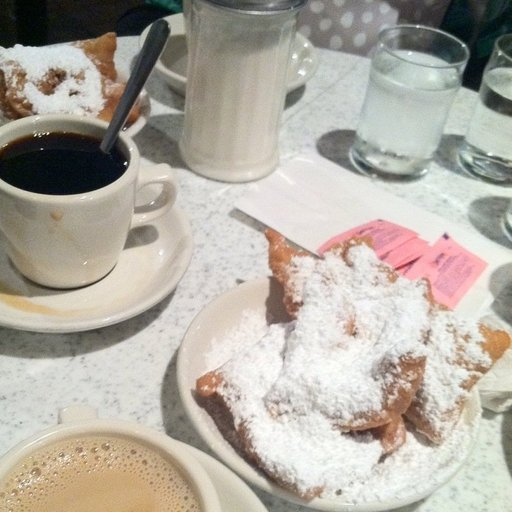

In [18]:
from datasets import load_dataset

ds = load_dataset("food101", split="validation[:100]")
image = ds["image"][0]
image

In [19]:
from transformers import AutoImageProcessor
import torch

image_processor = AutoImageProcessor.from_pretrained("vit_food101/checkpoint-399")
# 读的是里面的preprocessor_config.json(这个好像没有经过自己训练，跟官网上面哪个一样)
inputs = image_processor(image, return_tensors="pt")
inputs

{'pixel_values': tensor([[[[-0.8588, -0.8745, -0.8431,  ..., -0.8118, -0.7961, -0.8745],
          [-0.8902, -0.8667, -0.8510,  ..., -0.7882, -0.8196, -0.9137],
          [-0.8745, -0.8824, -0.8745,  ..., -0.7647, -0.8353, -0.8824],
          ...,
          [ 0.5608,  0.5608,  0.4902,  ...,  0.6549,  0.6863,  0.6784],
          [ 0.5059,  0.5608,  0.5529,  ...,  0.6706,  0.6627,  0.6706],
          [ 0.5765,  0.5686,  0.5843,  ...,  0.6941,  0.6235,  0.6000]],

         [[-0.8510, -0.8510, -0.8196,  ..., -0.6784, -0.6471, -0.7176],
          [-0.8745, -0.8431, -0.8275,  ..., -0.6706, -0.6784, -0.7569],
          [-0.8588, -0.8588, -0.8510,  ..., -0.6549, -0.6941, -0.7333],
          ...,
          [ 0.3804,  0.3961,  0.3333,  ...,  0.7098,  0.7412,  0.7333],
          [ 0.3176,  0.3882,  0.3882,  ...,  0.7255,  0.7176,  0.7255],
          [ 0.3882,  0.3961,  0.4196,  ...,  0.7490,  0.6784,  0.6549]],

         [[-0.8980, -0.9059, -0.8902,  ..., -0.6863, -0.6784, -0.7725],
          [-0

In [20]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("vit_food101/checkpoint-399")
# model读的有里面的pytorch_model.bin
with torch.no_grad():
    logits = model(**inputs).logits

predicted_label = logits.argmax(-1).item()
model.config.id2label[predicted_label]

'beignets'

In [21]:
image_2 = ds["image"][26]
inputs_2 = image_processor(image_2 , return_tensor="pt")
with torch.no_grad():
    logits = model(**inputs).logits

predicted_label = logits.argmax(-1).item()

In [22]:
predicted_label

6

In [23]:
model.config.id2label[predicted_label]

'beignets'

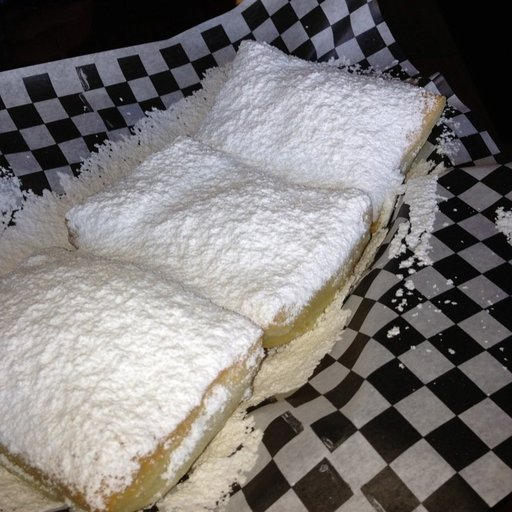

In [24]:
image_2

## 拆一下那个模型玩玩

In [25]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

In [34]:
import torch
import torch.nn as nn

ViTModel = list(model.children())[0]
ViTModel

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0): ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
      

In [43]:
ViTModel(**inputs)

BaseModelOutputWithPooling(last_hidden_state=tensor([[[-0.0550, -0.1800,  0.0810,  ..., -0.5182, -0.1000, -0.1232],
         [-0.0823, -0.1381,  0.0929,  ..., -0.3842,  0.0826, -0.1079],
         [-0.1223, -0.1501,  0.1151,  ..., -0.3841,  0.0550, -0.1158],
         ...,
         [ 0.0152, -0.0689,  0.0982,  ..., -0.3980,  0.0795,  0.0375],
         [-0.0155, -0.0263,  0.0550,  ..., -0.3322,  0.0215, -0.1329],
         [-0.0098, -0.0326,  0.0840,  ..., -0.3662,  0.0817, -0.0780]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=None, hidden_states=None, attentions=None)

In [44]:
ViTModel(**inputs)["last_hidden_state"].shape

torch.Size([1, 197, 768])

In [45]:
my_model = torch.load("vit_food101/checkpoint-399/pytorch_model.bin")
my_model #原来存储的只有参数

{'vit.embeddings.cls_token': tensor([[[-8.1316e-04,  5.8300e-03, -2.4512e-01, -7.2203e-04,  3.7859e-01,
            4.4570e-02, -1.3242e-02,  1.0922e-02,  2.9960e-02, -2.0998e-01,
           -7.6824e-03, -7.3955e-03, -8.1842e-03, -6.9392e-03, -1.1057e-02,
           -4.5860e-03, -5.7393e-04,  6.0445e-02,  2.8896e-02, -5.7695e-03,
           -5.2337e-02, -4.6897e-03, -3.7075e-03, -1.9486e-02, -8.0701e-04,
            5.0430e-02,  2.2007e-03, -9.3040e-03,  3.8812e-02, -3.1066e-02,
           -2.0468e-03,  1.7125e-02, -1.6490e-02,  7.4891e-03,  2.0753e-02,
            1.2187e-03,  4.3898e-02,  3.5524e-03, -1.6235e-03,  7.3150e-03,
            6.2629e-03,  7.7921e-03,  1.7832e-02,  3.5149e-03,  5.6980e-02,
            4.0802e-01, -2.3401e-03,  1.1285e-02,  2.6992e-02, -1.4117e-03,
           -9.7554e-03, -4.3942e-02,  6.3619e-03, -4.2157e-04,  2.0651e-03,
           -7.0528e-03, -4.6226e-03, -7.9718e-03,  1.0413e-02, -6.8878e-02,
           -1.2835e-02,  1.0305e-03, -3.4651e-03, -9.2159e-0